# Goal:

In this assignment, you will implement a [DDPM](https://arxiv.org/abs/2006.11239) class on MNIST dataset using PyTorch according to the guidence. The goal is to minimize the loss function and train the model to generate MNIST images.

The `Train` and `UNet` classes are already implemented for you. You need to implement the `DDPM` class (see details below). The images generated by the model will be automatically shown according to the `Trainer` class implementation. Make sure the generated images are shown in the output, it will be graded.

Grade:
- **DDPM class implementation (20 points).**
- **Training the model to generate reasonable MNIST images within 20 epochs (10 points).**
- **Write a report to describe include the sample images generated by each epochs (10 points). Please note that the function to generate the image is already provided.**
---
Please DO NOT change the code provided, only add your own code where indicated. It is recommended that you **use CPU session to debug** when GPU is not necessary since Colab only gives 12 hrs of free GPU access at a time. If you use up the GPU resource, you may consider using Kaggle GPU resource. Thank you and good luck!

# Pre-determined config and given functions (no need to change)

In [ ]:
!pip install labml_nn labml labml_helpers --no-deps
import torch
import torch.utils.data
import torchvision
from torch import nn
from labml_nn.diffusion.ddpm.unet import UNet
from typing import Tuple, Optional
import torch.nn.functional as F
from tqdm import tqdm
from easydict import EasyDict
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast

args = {
    "image_channels": 1,  # Number of channels in the image. 3 for RGB.
    "image_size": 32,  # Image size
    "n_channels": 64,  # Number of channels in the initial feature map
    "channel_multipliers": [
        1,
        2,
        2,
        4,
    ],  # The list of channel numbers at each resolution.
    "is_attention": [
        False,
        False,
        False,
        True,
    ],  # The list of booleans for attention at each resolution
    "n_steps": 1000,  # Number of time steps T
    "nb_save": 5,  # Number of images to save
    "batch_size": 256,  # Batch size
    "n_samples": 16,  # Number of samples to generate
    "learning_rate": 2e-5,  # Learning rate
    "epochs": 20,  # Number of training epochs
    "device": "cuda" if torch.cuda.is_available() else "cpu",  # Device
    "fp16_precision": False
}
args = EasyDict(args)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.9 MB/s eta 0:00:00


In [ ]:
class MNISTDataset(torchvision.datasets.MNIST):
    def __init__(self):
        transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(args.image_size),
                torchvision.transforms.ToTensor(),
            ]
        )

        super().__init__(
            ".", train=True, download=True, transform=transform
        )

    def __getitem__(self, item):
        return super().__getitem__(item)[0]

In [ ]:
class Trainer:
    def __init__(self, args, DenoiseDiffusion):

        self.eps_model = UNet(
            image_channels=args.image_channels,
            n_channels=args.n_channels,
            ch_mults=args.channel_multipliers,
            is_attn=args.is_attention,
        ).to(args.device)

        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=args.n_steps,
            device=args.device,
        )

        self.optimizer = torch.optim.Adam(
            self.eps_model.parameters(), lr=args.learning_rate
        )
        self.args = args

    def train_a_round(self, dataloader, scaler):
        for data in dataloader:
            # Move data to device
            data = data.to(args.device)

            # Calculate the loss
            with autocast(enabled=self.args.fp16_precision):
                loss = self.diffusion.loss(data)
            # Zero gradients
            self.optimizer.zero_grad()
            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

    def run_in_a_row(self, dataloader):
        scaler = GradScaler(enabled=self.args.fp16_precision)
        for current_epoch in tqdm(range(self.args.epochs)):
            self.current_epoch = current_epoch
            self.train_a_round(dataloader, scaler)
            self.sample()

    def sample(self):
        with torch.no_grad():
            # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
            x = torch.randn(
                [
                    self.args.n_samples,
                    self.args.image_channels,
                    self.args.image_size,
                    self.args.image_size,
                ],
                device=self.args.device,
            )
            if self.args.nb_save is not None:
                saving_steps = [self.args["n_steps"] - 1]
            # Remove noise for $T$ steps
            for t_ in tqdm(range(self.args.n_steps)):
                # $t$
                t = self.args.n_steps - t_ - 1
                # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
                x = self.diffusion.p_sample(
                    x, x.new_full((self.args.n_samples,), t, dtype=torch.long)
                )
                if self.args.nb_save is not None and t_ in saving_steps:
                    print(f"Showing/saving samples from epoch {self.current_epoch}")
                    show_save(
                        x,
                        show=True,
                        save=True,
                        file_name=f"epoch_{self.current_epoch}_sample_{t_}.png",
                    )
        return x


def show_save(img_tensor, show=True, save=True, file_name="sample.png"):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))  # Create a 4x4 grid of subplots
    assert img_tensor.shape[0] >= 9, "Number of images should be at least 9"
    img_tensor = img_tensor[:9]
    for i, ax in enumerate(axs.flat):
        # Remove the channel dimension and convert to numpy
        img = img_tensor[i].squeeze().cpu().numpy()

        ax.imshow(img, cmap="gray")  # Display the image in grayscale
        ax.axis("off")  # Hide the axis

    plt.tight_layout()
    if save:
        plt.savefig(file_name)
    if show:
        plt.show()
    plt.close(fig)

# Finish the DenoiseDiffusion model implementation

According to what the lecture is covered ([slides](https://www.dropbox.com/s/0gu91rovro71q90/Diffusion.pdf?dl=0)),

The `Trainer`, `dataset` and `UNet` are given.

We initialize ${\epsilon_\theta}(x_t, t)$, $\beta_1, \dots, \beta_T$ (linearly increasing variance schedule), $\alpha_t = 1 - \beta_t$, $\bar\alpha_t = \prod_{s=1}^t \alpha_s$, $\sigma^2 = \beta$
```python
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta
```

## q_xt_x0
We need to implment the function:
```python
    def q_xt_x0(
        self, x0: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        ...
        return mean, var
```
\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

Hint: Use the given gather function. Read more about `gather()` [here](https://pytorch.org/docs/stable/generated/torch.gather.html).

## q_sample

We need to implment the function to get samples from $q(x_t|x_0)$.

\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

Hint: sampling from $\mathcal{N} \Big(\mu, \sigma^2\Big)$ is the same as sampling from $\mathcal{N} \Big(0, I\Big)$ then scale and shift.

## p_sample
We need to implment the function to get samples from ${p_\theta}(x_{t-1}|x_t)$

\begin{align}
{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
{\mu_\theta}(x_t, t)
  &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
    \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}{\epsilon_\theta}(x_t, t) \Big)
\end{align}

*   `beta` is defined as $1-\alpha_t$  
*   `eps_coef` is defined as $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
*   `mu_theta` is defined as $\frac{1}{\sqrt{\alpha_t}} \Big(x_t -\frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)$
*   `var` is defined as $\sigma_t^2 \mathbf{I}$

## loss
We need to implment the function to get the loss:
$$L(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
\epsilon - {\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
\bigg\Vert^2 \Bigg]$$

where `x_t` is sampled from $q(x_t|x_0)$ which is given by $\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon$


In [ ]:
import torch.nn.functional as F

class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def gather(self, c: torch.Tensor, t: torch.Tensor):
        c_ = c.gather(-1, t)
        return c_.reshape(-1, 1, 1, 1)

    def q_xt_x0(
        self, x0: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # TODO
        alpha_bar = self.gather(self.alpha_bar, t)
        mean = torch.sqrt(alpha_bar) * x0
        var = (1 - alpha_bar) * torch.ones(x0.shape, device=x0.device)
        return mean, var

    def q_sample(
        self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None
    ):
        if eps is None:
            eps = torch.randn_like(x0)
        # TODO
        mean, var = self.q_xt_x0(x0, t)
        sample = torch.sqrt(var) * eps + mean
        return sample

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        print(eps_theta.shape)
        # TODO
        alpha_bar = self.gather(self.alpha_bar, t)
        alpha = self.gather(self.alpha, t)
        beta = self.gather(self.beta, t)
        eps_coef = beta/torch.sqrt(1 - alpha_bar)
        mu_theta = (1/torch.sqrt(alpha))*(xt - eps_coef * eps_theta)
        sigma2 = self.gather(self.sigma2, t)
        var = sigma2 * torch.ones(xt.shape, device=xt.device)
        eps = torch.randn(xt.shape, device=xt.device)
        sample = torch.sqrt(var) * eps + mu_theta
        return sample

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(
            0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long
        ) # t drawn randomly between 0 and T to calculate the loss
        if noise is None:
            noise = torch.randn_like(x0)
        # TODO
        xt = self.q_sample(x0, t, noise)
        eps_theta = self.eps_model(xt, t)
        #loss = torch.norm((noise-eps_theta), p=2)
        loss = F.mse_loss(noise, eps_theta)
        return loss


# Start training when you finish filling the code above
Expected time: About `400s` for each epoch (`20 epoches` in total), if you don't change the config parameters. No model-checkpoint-saving logic is implemented. Please feel free to implement it if you need it. There will be samples displayed and saved (in `.png` images) during training for every epoch. You should be able to find the saved images in the `Files` on the left hand side if you are using Google colab.

Notice: `20 epoches` in total is just a safe setting to generate MNIST-style images. Usually, it should start to generate interpretable images around `8 epoches`. If you don't see this, there may be something wrong with your implementation. Please double check your code before trying to having more epoches of training. Thanks!

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

  0%|          | 3/1000

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  1%|          | 9/1000 [00:00<00:51, 19.38it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  1%|▏         | 13/1000 [00:00<00:52, 18.67it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  2%|▏         | 17/1000 [00:00<00:53, 18.49it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  2%|▏         | 21/1000 [00:01<00:53, 18.30it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  2%|▎         | 25/1000 [00:01<00:53, 18.39it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  3%|▎         | 29/1000 [00:01<00:52, 18.37it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  3%|▎         | 33/1000 [00:01<00:52, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  4%|▎         | 37/1000 [00:01<00:52, 18.29it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  4%|▍         | 41/1000 [00:02<00:52, 18.35it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  4%|▍         | 45/1000 [00:02<00:52, 18.32it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  5%|▍         | 49/1000 [00:02<00:52, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  5%|▌         | 53/1000 [00:02<00:52, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  6%|▌         | 57/1000 [00:03<00:51, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  6%|▌         | 61/1000 [00:03<00:51, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  6%|▋         | 65/1000 [00:03<00:51, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  7%|▋         | 69/1000 [00:03<00:50, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  7%|▋         | 73/1000 [00:03<00:51, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  8%|▊         | 77/1000 [00:04<00:50, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  8%|▊         | 81/1000 [00:04<00:50, 18.29it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  8%|▊         | 85/1000 [00:04<00:50, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  9%|▉         | 89/1000 [00:04<00:49, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  9%|▉         | 93/1000 [00:05<00:49, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 10%|▉         | 97/1000 [00:05<00:49, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 10%|█         | 101/1000 [00:05<00:49, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 10%|█         | 105/1000 [00:05<00:49, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 11%|█         | 109/1000 [00:05<00:48, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 11%|█▏        | 113/1000 [00:06<00:48, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 12%|█▏        | 117/1000 [00:06<00:48, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 12%|█▏        | 121/1000 [00:06<00:48, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 12%|█▎        | 125/1000 [00:06<00:48, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 13%|█▎        | 129/1000 [00:07<00:47, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 13%|█▎        | 133/1000 [00:07<00:47, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 14%|█▎        | 137/1000 [00:07<00:47, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 14%|█▍        | 141/1000 [00:07<00:47, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 14%|█▍        | 145/1000 [00:07<00:46, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 15%|█▍        | 149/1000 [00:08<00:46, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 15%|█▌        | 153/1000 [00:08<00:46, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 16%|█▌        | 157/1000 [00:08<00:46, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 16%|█▌        | 161/1000 [00:08<00:46, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 16%|█▋        | 165/1000 [00:09<00:45, 18.31it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 17%|█▋        | 169/1000 [00:09<00:45, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 17%|█▋        | 173/1000 [00:09<00:45, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 18%|█▊        | 177/1000 [00:09<00:45, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 18%|█▊        | 181/1000 [00:09<00:45, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 18%|█▊        | 185/1000 [00:10<00:44, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 19%|█▉        | 189/1000 [00:10<00:44, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 19%|█▉        | 193/1000 [00:10<00:44, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 20%|█▉        | 197/1000 [00:10<00:44, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 20%|██        | 201/1000 [00:10<00:43, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 20%|██        | 205/1000 [00:11<00:43, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 21%|██        | 209/1000 [00:11<00:43, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 21%|██▏       | 213/1000 [00:11<00:43, 18.06it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 22%|██▏       | 217/1000 [00:11<00:43, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 22%|██▏       | 221/1000 [00:12<00:42, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 22%|██▎       | 225/1000 [00:12<00:42, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 23%|██▎       | 229/1000 [00:12<00:42, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 23%|██▎       | 233/1000 [00:12<00:42, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 24%|██▎       | 237/1000 [00:12<00:42, 17.97it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 24%|██▍       | 241/1000 [00:13<00:41, 18.32it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 24%|██▍       | 245/1000 [00:13<00:41, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 25%|██▍       | 249/1000 [00:13<00:41, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 25%|██▌       | 253/1000 [00:13<00:40, 18.30it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 26%|██▌       | 257/1000 [00:14<00:40, 18.30it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 26%|██▌       | 261/1000 [00:14<00:40, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 26%|██▋       | 265/1000 [00:14<00:40, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 27%|██▋       | 269/1000 [00:14<00:40, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 27%|██▋       | 273/1000 [00:14<00:40, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 28%|██▊       | 277/1000 [00:15<00:39, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 28%|██▊       | 281/1000 [00:15<00:39, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 28%|██▊       | 285/1000 [00:15<00:39, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 29%|██▉       | 289/1000 [00:15<00:39, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 29%|██▉       | 293/1000 [00:16<00:38, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 30%|██▉       | 297/1000 [00:16<00:38, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 30%|███       | 301/1000 [00:16<00:38, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 30%|███       | 305/1000 [00:16<00:38, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 31%|███       | 309/1000 [00:16<00:37, 18.29it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 31%|███▏      | 313/1000 [00:17<00:37, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 32%|███▏      | 317/1000 [00:17<00:37, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 32%|███▏      | 321/1000 [00:17<00:37, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 32%|███▎      | 325/1000 [00:17<00:37, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 33%|███▎      | 329/1000 [00:18<00:37, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 33%|███▎      | 333/1000 [00:18<00:36, 18.31it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 34%|███▎      | 337/1000 [00:18<00:36, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 34%|███▍      | 341/1000 [00:18<00:36, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 34%|███▍      | 345/1000 [00:18<00:35, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 35%|███▍      | 349/1000 [00:19<00:35, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 35%|███▌      | 353/1000 [00:19<00:35, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 36%|███▌      | 357/1000 [00:19<00:35, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 36%|███▌      | 361/1000 [00:19<00:35, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 36%|███▋      | 365/1000 [00:19<00:34, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 37%|███▋      | 369/1000 [00:20<00:34, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 37%|███▋      | 373/1000 [00:20<00:34, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 38%|███▊      | 377/1000 [00:20<00:34, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 38%|███▊      | 381/1000 [00:20<00:34, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 38%|███▊      | 385/1000 [00:21<00:33, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 39%|███▉      | 389/1000 [00:21<00:33, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 39%|███▉      | 393/1000 [00:21<00:33, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 40%|███▉      | 397/1000 [00:21<00:33, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 40%|████      | 401/1000 [00:21<00:32, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 40%|████      | 405/1000 [00:22<00:32, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 41%|████      | 409/1000 [00:22<00:32, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 41%|████▏     | 413/1000 [00:22<00:32, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 42%|████▏     | 417/1000 [00:22<00:32, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 42%|████▏     | 421/1000 [00:23<00:31, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 42%|████▎     | 425/1000 [00:23<00:31, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 43%|████▎     | 429/1000 [00:23<00:31, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 43%|████▎     | 433/1000 [00:23<00:31, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 44%|████▎     | 437/1000 [00:23<00:30, 18.30it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 44%|████▍     | 441/1000 [00:24<00:30, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 44%|████▍     | 445/1000 [00:24<00:30, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 45%|████▍     | 449/1000 [00:24<00:30, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 45%|████▌     | 453/1000 [00:24<00:29, 18.36it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 46%|████▌     | 457/1000 [00:25<00:29, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 46%|████▌     | 461/1000 [00:25<00:29, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 46%|████▋     | 465/1000 [00:25<00:29, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 47%|████▋     | 469/1000 [00:25<00:29, 18.05it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 47%|████▋     | 473/1000 [00:25<00:28, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 48%|████▊     | 477/1000 [00:26<00:28, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 48%|████▊     | 481/1000 [00:26<00:28, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 48%|████▊     | 485/1000 [00:26<00:28, 18.34it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 49%|████▉     | 489/1000 [00:26<00:28, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 49%|████▉     | 493/1000 [00:27<00:27, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 50%|████▉     | 497/1000 [00:27<00:27, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 50%|█████     | 501/1000 [00:27<00:27, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 50%|█████     | 505/1000 [00:27<00:26, 18.36it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 51%|█████     | 509/1000 [00:27<00:26, 18.41it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 51%|█████▏    | 513/1000 [00:28<00:26, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 52%|█████▏    | 517/1000 [00:28<00:26, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 52%|█████▏    | 521/1000 [00:28<00:26, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 52%|█████▎    | 525/1000 [00:28<00:26, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 53%|█████▎    | 529/1000 [00:28<00:25, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 53%|█████▎    | 533/1000 [00:29<00:25, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 54%|█████▎    | 537/1000 [00:29<00:25, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 54%|█████▍    | 541/1000 [00:29<00:25, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 55%|█████▍    | 545/1000 [00:29<00:24, 18.34it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 55%|█████▍    | 549/1000 [00:30<00:24, 18.31it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 55%|█████▌    | 553/1000 [00:30<00:24, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 56%|█████▌    | 557/1000 [00:30<00:24, 18.34it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 56%|█████▌    | 561/1000 [00:30<00:23, 18.30it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 56%|█████▋    | 565/1000 [00:30<00:23, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 57%|█████▋    | 569/1000 [00:31<00:23, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 57%|█████▋    | 573/1000 [00:31<00:23, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 58%|█████▊    | 577/1000 [00:31<00:23, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 58%|█████▊    | 581/1000 [00:31<00:22, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 58%|█████▊    | 585/1000 [00:32<00:22, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 59%|█████▉    | 589/1000 [00:32<00:22, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 59%|█████▉    | 593/1000 [00:32<00:22, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 60%|█████▉    | 597/1000 [00:32<00:22, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 60%|██████    | 601/1000 [00:32<00:21, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 60%|██████    | 605/1000 [00:33<00:21, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 61%|██████    | 609/1000 [00:33<00:21, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 61%|██████▏   | 613/1000 [00:33<00:21, 18.33it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 62%|██████▏   | 617/1000 [00:33<00:20, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 62%|██████▏   | 621/1000 [00:34<00:20, 18.33it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 62%|██████▎   | 625/1000 [00:34<00:20, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 63%|██████▎   | 629/1000 [00:34<00:20, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 63%|██████▎   | 633/1000 [00:34<00:20, 18.30it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 64%|██████▎   | 637/1000 [00:34<00:19, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 64%|██████▍   | 641/1000 [00:35<00:19, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 64%|██████▍   | 645/1000 [00:35<00:19, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 65%|██████▍   | 649/1000 [00:35<00:19, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 65%|██████▌   | 653/1000 [00:35<00:19, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 66%|██████▌   | 657/1000 [00:36<00:18, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 66%|██████▌   | 661/1000 [00:36<00:18, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 66%|██████▋   | 665/1000 [00:36<00:18, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 67%|██████▋   | 669/1000 [00:36<00:18, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 67%|██████▋   | 673/1000 [00:36<00:17, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 68%|██████▊   | 677/1000 [00:37<00:17, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 68%|██████▊   | 681/1000 [00:37<00:17, 18.30it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 68%|██████▊   | 685/1000 [00:37<00:17, 18.29it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 69%|██████▉   | 689/1000 [00:37<00:16, 18.31it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 69%|██████▉   | 693/1000 [00:37<00:16, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 70%|██████▉   | 697/1000 [00:38<00:16, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 70%|███████   | 701/1000 [00:38<00:16, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 70%|███████   | 705/1000 [00:38<00:16, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 71%|███████   | 709/1000 [00:38<00:15, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 71%|███████▏  | 713/1000 [00:39<00:15, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 72%|███████▏  | 717/1000 [00:39<00:15, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 72%|███████▏  | 721/1000 [00:39<00:15, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 72%|███████▎  | 725/1000 [00:39<00:14, 18.34it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 73%|███████▎  | 729/1000 [00:39<00:14, 18.33it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 73%|███████▎  | 733/1000 [00:40<00:14, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 74%|███████▎  | 737/1000 [00:40<00:14, 18.31it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 74%|███████▍  | 741/1000 [00:40<00:14, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 74%|███████▍  | 745/1000 [00:40<00:13, 18.35it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 75%|███████▍  | 749/1000 [00:41<00:13, 18.33it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 75%|███████▌  | 753/1000 [00:41<00:13, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 76%|███████▌  | 757/1000 [00:41<00:13, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 76%|███████▌  | 761/1000 [00:41<00:13, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 76%|███████▋  | 765/1000 [00:41<00:12, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 77%|███████▋  | 769/1000 [00:42<00:12, 18.33it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 77%|███████▋  | 773/1000 [00:42<00:12, 18.33it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 78%|███████▊  | 777/1000 [00:42<00:12, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 78%|███████▊  | 781/1000 [00:42<00:12, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 78%|███████▊  | 785/1000 [00:43<00:11, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 79%|███████▉  | 789/1000 [00:43<00:11, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 79%|███████▉  | 793/1000 [00:43<00:11, 18.32it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 80%|███████▉  | 797/1000 [00:43<00:11, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 80%|████████  | 801/1000 [00:43<00:10, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 80%|████████  | 805/1000 [00:44<00:10, 18.30it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 81%|████████  | 809/1000 [00:44<00:10, 18.31it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 81%|████████▏ | 813/1000 [00:44<00:10, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 82%|████████▏ | 817/1000 [00:44<00:10, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 82%|████████▏ | 821/1000 [00:44<00:09, 18.31it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 82%|████████▎ | 825/1000 [00:45<00:09, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 83%|████████▎ | 829/1000 [00:45<00:09, 18.29it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 83%|████████▎ | 833/1000 [00:45<00:09, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 84%|████████▎ | 837/1000 [00:45<00:08, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 84%|████████▍ | 841/1000 [00:46<00:08, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 84%|████████▍ | 845/1000 [00:46<00:08, 18.34it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 85%|████████▍ | 849/1000 [00:46<00:08, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 85%|████████▌ | 853/1000 [00:46<00:08, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 86%|████████▌ | 857/1000 [00:46<00:07, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 86%|████████▌ | 861/1000 [00:47<00:07, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 86%|████████▋ | 865/1000 [00:47<00:07, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 87%|████████▋ | 869/1000 [00:47<00:07, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 87%|████████▋ | 873/1000 [00:47<00:06, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 88%|████████▊ | 877/1000 [00:48<00:06, 18.26it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 88%|████████▊ | 881/1000 [00:48<00:06, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 88%|████████▊ | 885/1000 [00:48<00:06, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 89%|████████▉ | 889/1000 [00:48<00:06, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 89%|████████▉ | 893/1000 [00:48<00:05, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 90%|████████▉ | 897/1000 [00:49<00:05, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 90%|█████████ | 901/1000 [00:49<00:05, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 90%|█████████ | 905/1000 [00:49<00:05, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 91%|█████████ | 909/1000 [00:49<00:04, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 91%|█████████▏| 913/1000 [00:50<00:04, 18.33it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 92%|█████████▏| 917/1000 [00:50<00:04, 18.32it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 92%|█████████▏| 921/1000 [00:50<00:04, 18.33it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 92%|█████████▎| 925/1000 [00:50<00:04, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 93%|█████████▎| 929/1000 [00:50<00:03, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 93%|█████████▎| 933/1000 [00:51<00:03, 18.29it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 94%|█████████▎| 937/1000 [00:51<00:03, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 94%|█████████▍| 941/1000 [00:51<00:03, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 94%|█████████▍| 945/1000 [00:51<00:03, 18.30it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 95%|█████████▍| 949/1000 [00:52<00:02, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 95%|█████████▌| 953/1000 [00:52<00:02, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 96%|█████████▌| 957/1000 [00:52<00:02, 18.37it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 96%|█████████▌| 961/1000 [00:52<00:02, 18.35it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 96%|█████████▋| 965/1000 [00:52<00:01, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 97%|█████████▋| 969/1000 [00:53<00:01, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 97%|█████████▋| 973/1000 [00:53<00:01, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 98%|█████████▊| 977/1000 [00:53<00:01, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 98%|█████████▊| 981/1000 [00:53<00:01, 18.33it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 98%|█████████▊| 985/1000 [00:53<00:00, 18.31it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 99%|█████████▉| 989/1000 [00:54<00:00, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 99%|█████████▉| 993/1000 [00:54<00:00, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



100%|█████████▉| 997/1000 [00:54<00:00, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



100%|█████████▉| 999/1000 [00:54<00:00, 18.29it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
Showing/saving samples from epoch 0


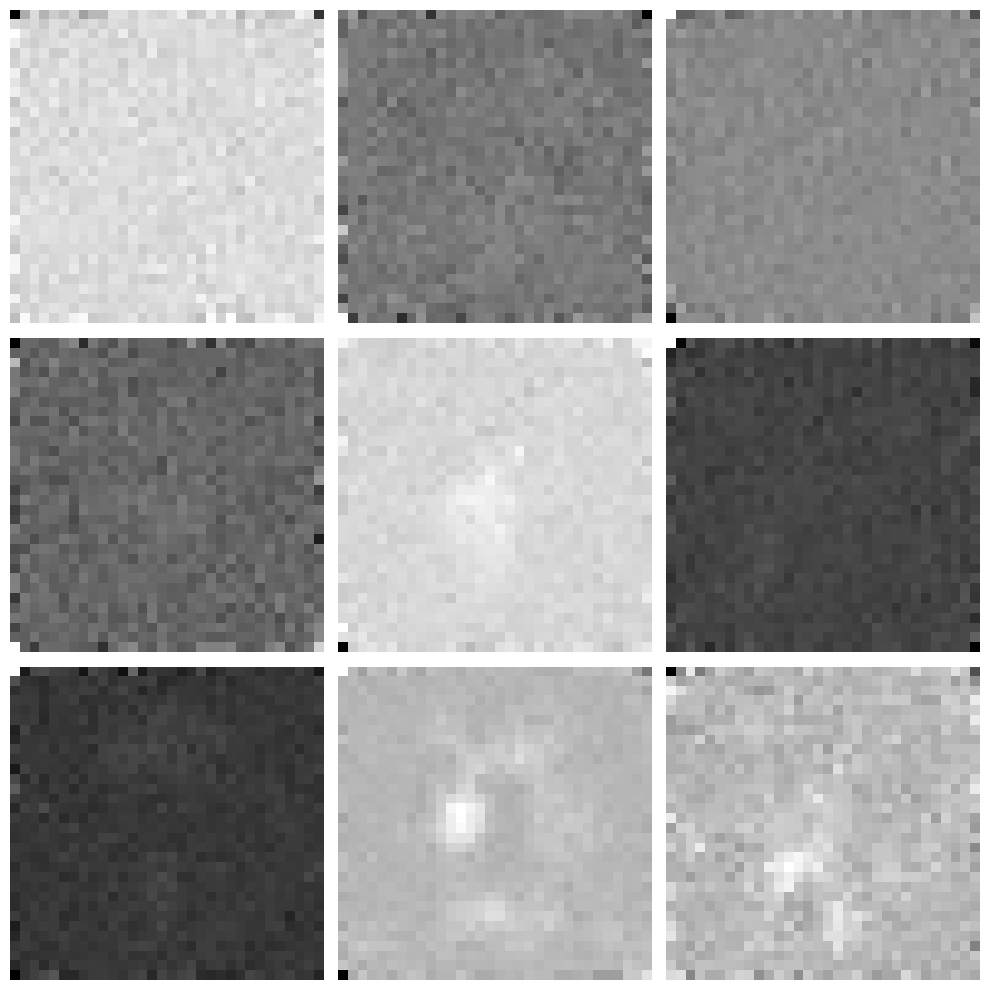

  0%|          | 4/1000 [00:00<01:02, 15.90it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  1%|          | 8/1000 [00:00<00:56, 17.41it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  1%|          | 12/1000 [00:00<00:55, 17.76it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  2%|▏         | 16/1000 [00:00<00:54, 18.04it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  2%|▏         | 20/1000 [00:01<00:54, 17.99it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  2%|▏         | 24/1000 [00:01<00:53, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  3%|▎         | 28/1000 [00:01<00:53, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  3%|▎         | 32/1000 [00:01<00:53, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  4%|▎         | 36/1000 [00:02<00:53, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  4%|▍         | 40/1000 [00:02<00:52, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  4%|▍         | 44/1000 [00:02<00:52, 18.04it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  5%|▍         | 48/1000 [00:02<00:52, 18.02it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  5%|▌         | 52/1000 [00:02<00:52, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  6%|▌         | 56/1000 [00:03<00:52, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  6%|▌         | 60/1000 [00:03<00:51, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  6%|▋         | 64/1000 [00:03<00:51, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  7%|▋         | 68/1000 [00:03<00:51, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  7%|▋         | 72/1000 [00:04<00:51, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  8%|▊         | 76/1000 [00:04<00:50, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  8%|▊         | 80/1000 [00:04<00:50, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  8%|▊         | 84/1000 [00:04<00:50, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  9%|▉         | 88/1000 [00:04<00:50, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



  9%|▉         | 92/1000 [00:05<00:49, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 10%|▉         | 96/1000 [00:05<00:50, 17.90it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 10%|█         | 100/1000 [00:05<00:49, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 10%|█         | 104/1000 [00:05<00:49, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 11%|█         | 108/1000 [00:05<00:49, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 11%|█         | 112/1000 [00:06<00:49, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 12%|█▏        | 116/1000 [00:06<00:48, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 12%|█▏        | 120/1000 [00:06<00:48, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 12%|█▏        | 124/1000 [00:06<00:48, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 13%|█▎        | 128/1000 [00:07<00:48, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 13%|█▎        | 132/1000 [00:07<00:47, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 14%|█▎        | 136/1000 [00:07<00:47, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 14%|█▍        | 140/1000 [00:07<00:47, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 14%|█▍        | 144/1000 [00:07<00:47, 17.98it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 15%|█▍        | 148/1000 [00:08<00:47, 18.05it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 15%|█▌        | 152/1000 [00:08<00:46, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 16%|█▌        | 156/1000 [00:08<00:46, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 16%|█▌        | 160/1000 [00:08<00:46, 18.04it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 16%|█▋        | 164/1000 [00:09<00:46, 18.05it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 17%|█▋        | 168/1000 [00:09<00:46, 18.03it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 17%|█▋        | 172/1000 [00:09<00:45, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 18%|█▊        | 176/1000 [00:09<00:45, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 18%|█▊        | 180/1000 [00:09<00:45, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 18%|█▊        | 184/1000 [00:10<00:44, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 19%|█▉        | 188/1000 [00:10<00:44, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 19%|█▉        | 192/1000 [00:10<00:44, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 20%|█▉        | 196/1000 [00:10<00:44, 18.05it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 20%|██        | 200/1000 [00:11<00:44, 18.03it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 20%|██        | 204/1000 [00:11<00:43, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 21%|██        | 208/1000 [00:11<00:44, 17.93it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 21%|██        | 212/1000 [00:11<00:43, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 22%|██▏       | 216/1000 [00:11<00:43, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 22%|██▏       | 220/1000 [00:12<00:42, 18.28it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 22%|██▏       | 224/1000 [00:12<00:42, 18.27it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 23%|██▎       | 228/1000 [00:12<00:42, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 23%|██▎       | 232/1000 [00:12<00:42, 18.06it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 24%|██▎       | 236/1000 [00:13<00:42, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 24%|██▍       | 240/1000 [00:13<00:41, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 24%|██▍       | 244/1000 [00:13<00:41, 18.04it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 25%|██▍       | 248/1000 [00:13<00:41, 18.00it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 25%|██▌       | 252/1000 [00:13<00:41, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 26%|██▌       | 256/1000 [00:14<00:41, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 26%|██▌       | 260/1000 [00:14<00:40, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 26%|██▋       | 264/1000 [00:14<00:40, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 27%|██▋       | 268/1000 [00:14<00:40, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 27%|██▋       | 272/1000 [00:15<00:40, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 28%|██▊       | 276/1000 [00:15<00:39, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 28%|██▊       | 280/1000 [00:15<00:39, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 28%|██▊       | 284/1000 [00:15<00:39, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 29%|██▉       | 288/1000 [00:15<00:39, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 29%|██▉       | 292/1000 [00:16<00:38, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 30%|██▉       | 296/1000 [00:16<00:38, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 30%|███       | 300/1000 [00:16<00:38, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 30%|███       | 304/1000 [00:16<00:38, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 31%|███       | 308/1000 [00:17<00:38, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 31%|███       | 312/1000 [00:17<00:37, 18.31it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 32%|███▏      | 316/1000 [00:17<00:37, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 32%|███▏      | 320/1000 [00:17<00:37, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 32%|███▏      | 324/1000 [00:17<00:37, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 33%|███▎      | 328/1000 [00:18<00:37, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 33%|███▎      | 332/1000 [00:18<00:36, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 34%|███▎      | 336/1000 [00:18<00:36, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 34%|███▍      | 340/1000 [00:18<00:36, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 34%|███▍      | 344/1000 [00:19<00:35, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 35%|███▍      | 348/1000 [00:19<00:35, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 35%|███▌      | 352/1000 [00:19<00:35, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 36%|███▌      | 356/1000 [00:19<00:35, 18.02it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 36%|███▌      | 360/1000 [00:19<00:35, 18.25it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 36%|███▋      | 364/1000 [00:20<00:34, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 37%|███▋      | 368/1000 [00:20<00:34, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 37%|███▋      | 372/1000 [00:20<00:34, 18.06it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 38%|███▊      | 376/1000 [00:20<00:34, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 38%|███▊      | 380/1000 [00:20<00:34, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 38%|███▊      | 384/1000 [00:21<00:34, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 39%|███▉      | 388/1000 [00:21<00:33, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 39%|███▉      | 392/1000 [00:21<00:33, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 40%|███▉      | 396/1000 [00:21<00:33, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 40%|████      | 400/1000 [00:22<00:32, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 40%|████      | 404/1000 [00:22<00:32, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 41%|████      | 408/1000 [00:22<00:32, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 41%|████      | 412/1000 [00:22<00:32, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 42%|████▏     | 416/1000 [00:22<00:32, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 42%|████▏     | 420/1000 [00:23<00:31, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 42%|████▏     | 424/1000 [00:23<00:31, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 43%|████▎     | 428/1000 [00:23<00:31, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 43%|████▎     | 432/1000 [00:23<00:31, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 44%|████▎     | 436/1000 [00:24<00:31, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 44%|████▍     | 440/1000 [00:24<00:31, 18.05it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 44%|████▍     | 444/1000 [00:24<00:30, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 45%|████▍     | 448/1000 [00:24<00:30, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 45%|████▌     | 452/1000 [00:24<00:30, 18.00it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 46%|████▌     | 456/1000 [00:25<00:30, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 46%|████▌     | 460/1000 [00:25<00:29, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 46%|████▋     | 464/1000 [00:25<00:29, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 47%|████▋     | 468/1000 [00:25<00:29, 18.05it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 47%|████▋     | 472/1000 [00:26<00:29, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 48%|████▊     | 476/1000 [00:26<00:28, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 48%|████▊     | 480/1000 [00:26<00:28, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 48%|████▊     | 484/1000 [00:26<00:28, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 49%|████▉     | 488/1000 [00:26<00:28, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 49%|████▉     | 492/1000 [00:27<00:28, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 50%|████▉     | 496/1000 [00:27<00:28, 17.99it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 50%|█████     | 500/1000 [00:27<00:27, 17.97it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 50%|█████     | 504/1000 [00:27<00:27, 18.00it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 51%|█████     | 508/1000 [00:28<00:27, 18.06it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 51%|█████     | 512/1000 [00:28<00:26, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 52%|█████▏    | 516/1000 [00:28<00:26, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 52%|█████▏    | 520/1000 [00:28<00:26, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 52%|█████▏    | 524/1000 [00:28<00:26, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 53%|█████▎    | 528/1000 [00:29<00:25, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 53%|█████▎    | 532/1000 [00:29<00:25, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 54%|█████▎    | 536/1000 [00:29<00:25, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 54%|█████▍    | 540/1000 [00:29<00:25, 18.29it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 54%|█████▍    | 544/1000 [00:30<00:25, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 55%|█████▍    | 548/1000 [00:30<00:25, 17.99it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 55%|█████▌    | 552/1000 [00:30<00:24, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 56%|█████▌    | 556/1000 [00:30<00:24, 18.24it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 56%|█████▌    | 560/1000 [00:30<00:24, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 56%|█████▋    | 564/1000 [00:31<00:24, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 57%|█████▋    | 568/1000 [00:31<00:24, 17.99it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 57%|█████▋    | 572/1000 [00:31<00:23, 17.98it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 58%|█████▊    | 576/1000 [00:31<00:23, 17.97it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 58%|█████▊    | 580/1000 [00:32<00:23, 17.98it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 58%|█████▊    | 584/1000 [00:32<00:23, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 59%|█████▉    | 588/1000 [00:32<00:22, 18.00it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 59%|█████▉    | 592/1000 [00:32<00:22, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 60%|█████▉    | 596/1000 [00:32<00:22, 18.06it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 60%|██████    | 600/1000 [00:33<00:21, 18.21it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 60%|██████    | 604/1000 [00:33<00:21, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 61%|██████    | 608/1000 [00:33<00:21, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 61%|██████    | 612/1000 [00:33<00:21, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 62%|██████▏   | 616/1000 [00:34<00:21, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 62%|██████▏   | 620/1000 [00:34<00:20, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 62%|██████▏   | 624/1000 [00:34<00:20, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 63%|██████▎   | 628/1000 [00:34<00:20, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 63%|██████▎   | 632/1000 [00:34<00:20, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 64%|██████▎   | 636/1000 [00:35<00:20, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 64%|██████▍   | 640/1000 [00:35<00:19, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 64%|██████▍   | 644/1000 [00:35<00:19, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 65%|██████▍   | 648/1000 [00:35<00:19, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 65%|██████▌   | 652/1000 [00:36<00:19, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 66%|██████▌   | 656/1000 [00:36<00:19, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 66%|██████▌   | 660/1000 [00:36<00:18, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 66%|██████▋   | 664/1000 [00:36<00:18, 18.06it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 67%|██████▋   | 668/1000 [00:36<00:18, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 67%|██████▋   | 672/1000 [00:37<00:18, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 68%|██████▊   | 676/1000 [00:37<00:17, 18.19it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 68%|██████▊   | 680/1000 [00:37<00:17, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 68%|██████▊   | 684/1000 [00:37<00:17, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 69%|██████▉   | 688/1000 [00:37<00:17, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 69%|██████▉   | 692/1000 [00:38<00:17, 18.01it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 70%|██████▉   | 696/1000 [00:38<00:16, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 70%|███████   | 700/1000 [00:38<00:16, 18.04it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 70%|███████   | 704/1000 [00:38<00:16, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 71%|███████   | 708/1000 [00:39<00:16, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 71%|███████   | 712/1000 [00:39<00:15, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 72%|███████▏  | 716/1000 [00:39<00:15, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 72%|███████▏  | 720/1000 [00:39<00:15, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 72%|███████▏  | 724/1000 [00:39<00:15, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 73%|███████▎  | 728/1000 [00:40<00:14, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 73%|███████▎  | 732/1000 [00:40<00:14, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 74%|███████▎  | 736/1000 [00:40<00:14, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 74%|███████▍  | 740/1000 [00:40<00:14, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 74%|███████▍  | 744/1000 [00:41<00:14, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 75%|███████▍  | 748/1000 [00:41<00:14, 18.00it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 75%|███████▌  | 752/1000 [00:41<00:13, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 76%|███████▌  | 756/1000 [00:41<00:13, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 76%|███████▌  | 760/1000 [00:41<00:13, 17.92it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 76%|███████▋  | 764/1000 [00:42<00:13, 18.02it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 77%|███████▋  | 768/1000 [00:42<00:12, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 77%|███████▋  | 772/1000 [00:42<00:12, 18.17it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 78%|███████▊  | 776/1000 [00:42<00:12, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 78%|███████▊  | 780/1000 [00:43<00:12, 18.06it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 78%|███████▊  | 784/1000 [00:43<00:11, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 79%|███████▉  | 788/1000 [00:43<00:11, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 79%|███████▉  | 792/1000 [00:43<00:11, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 80%|███████▉  | 796/1000 [00:43<00:11, 17.89it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 80%|████████  | 800/1000 [00:44<00:11, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 80%|████████  | 804/1000 [00:44<00:10, 18.18it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 81%|████████  | 808/1000 [00:44<00:10, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 81%|████████  | 812/1000 [00:44<00:10, 18.22it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 82%|████████▏ | 816/1000 [00:45<00:10, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 82%|████████▏ | 820/1000 [00:45<00:09, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 82%|████████▏ | 824/1000 [00:45<00:09, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 83%|████████▎ | 828/1000 [00:45<00:09, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 83%|████████▎ | 832/1000 [00:45<00:09, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 84%|████████▎ | 836/1000 [00:46<00:09, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 84%|████████▍ | 840/1000 [00:46<00:08, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 84%|████████▍ | 844/1000 [00:46<00:08, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 85%|████████▍ | 848/1000 [00:46<00:08, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 85%|████████▌ | 852/1000 [00:47<00:08, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 86%|████████▌ | 856/1000 [00:47<00:07, 18.20it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 86%|████████▌ | 860/1000 [00:47<00:07, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 86%|████████▋ | 864/1000 [00:47<00:07, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 87%|████████▋ | 868/1000 [00:47<00:07, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 87%|████████▋ | 872/1000 [00:48<00:07, 17.97it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 88%|████████▊ | 876/1000 [00:48<00:06, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 88%|████████▊ | 880/1000 [00:48<00:06, 18.04it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 88%|████████▊ | 884/1000 [00:48<00:06, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 89%|████████▉ | 888/1000 [00:49<00:06, 18.23it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 89%|████████▉ | 892/1000 [00:49<00:05, 18.14it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 90%|████████▉ | 896/1000 [00:49<00:05, 18.10it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 90%|█████████ | 900/1000 [00:49<00:05, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 90%|█████████ | 904/1000 [00:49<00:05, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 91%|█████████ | 908/1000 [00:50<00:05, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 91%|█████████ | 912/1000 [00:50<00:04, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 92%|█████████▏| 916/1000 [00:50<00:04, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 92%|█████████▏| 920/1000 [00:50<00:04, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 92%|█████████▏| 924/1000 [00:51<00:04, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 93%|█████████▎| 928/1000 [00:51<00:03, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 93%|█████████▎| 932/1000 [00:51<00:03, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 94%|█████████▎| 936/1000 [00:51<00:03, 18.05it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 94%|█████████▍| 940/1000 [00:51<00:03, 18.07it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 94%|█████████▍| 944/1000 [00:52<00:03, 18.13it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 95%|█████████▍| 948/1000 [00:52<00:02, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 95%|█████████▌| 952/1000 [00:52<00:02, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 96%|█████████▌| 956/1000 [00:52<00:02, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 96%|█████████▌| 960/1000 [00:53<00:02, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 96%|█████████▋| 964/1000 [00:53<00:01, 18.08it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 97%|█████████▋| 968/1000 [00:53<00:01, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 97%|█████████▋| 972/1000 [00:53<00:01, 18.11it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 98%|█████████▊| 976/1000 [00:53<00:01, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 98%|█████████▊| 980/1000 [00:54<00:01, 18.15it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 98%|█████████▊| 984/1000 [00:54<00:00, 18.09it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 99%|█████████▉| 988/1000 [00:54<00:00, 18.01it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



 99%|█████████▉| 992/1000 [00:54<00:00, 17.94it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



100%|█████████▉| 996/1000 [00:55<00:00, 18.16it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])



100%|█████████▉| 998/1000 [00:55<00:00, 18.12it/s]

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])
Showing/saving samples from epoch 1


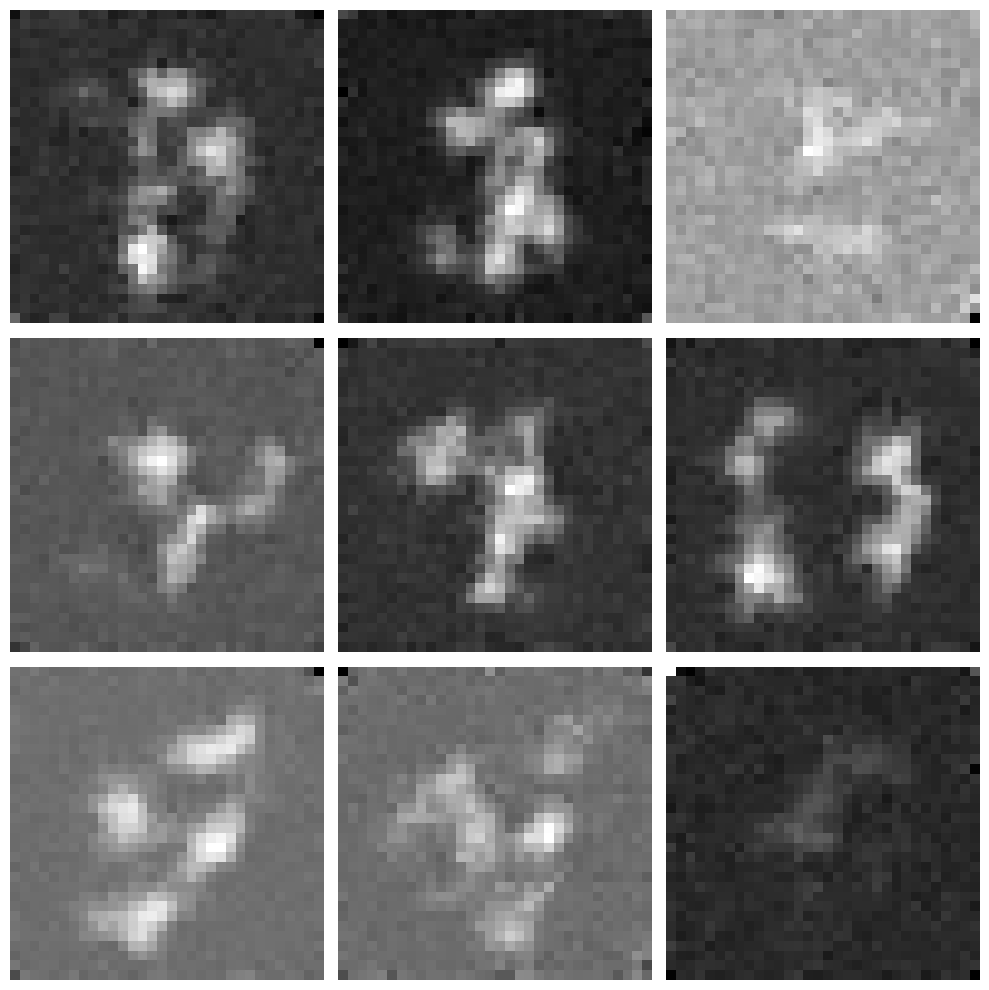


100%|██████████| 2/2 [12:23<00:00, 371.58s/it]


In [ ]:
trainer = Trainer(args, DenoiseDiffusion)
dataloader = torch.utils.data.DataLoader(
    MNISTDataset(),
    batch_size=args.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
)
trainer.run_in_a_row(dataloader)